**Table of contents**<a id='toc0_'></a>    
1. [Setup](#toc1_)    
2. [Get the data](#toc2_)    
3. [Preprocess the data](#toc3_)    
4. [LSTM](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import numpy as np
import pandas as pd

import torch
print(torch.__version__)
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
import datetime as dt
from pprint import pprint

import yfinance as yf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2.1.0+cu118


# 2. <a id='toc2_'></a>[Get the data](#toc0_)

In [2]:
# Override pandas datareader with yfinance
yf.pdr_override()

# Define the list of stock symbols
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

# Define the start and end dates for data retrieval
startdate = dt.datetime(2015, 1, 1)
enddate = dt.datetime(2020, 12, 31)

# Retrieve historical stock price data for the specified symbols and date range
df = yf.download(y_symbols, start=startdate, end=enddate)

# Stack the multi-level index to create a single-level index
df = df.stack(level=1)

# Reset the index to make 'Date' a regular column
df = df.reset_index()

# Rename the columns to match the desired structure
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Save to a csv file
df.to_csv("Data/df_stocks.csv", index=False)

df

[*********************100%%**********************]  5 of 5 completed


,Date,Stock,Adj Close,Close,High,Low,Open,Volume
0,2015-01-02,AAPL,24.498676,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268
3,2015-01-02,MSFT,40.534847,46.759998,47.419998,46.540001,46.660000,27913900
4,2015-01-02,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
...,...,...,...,...,...,...,...,...
7545,2020-12-30,AAPL,131.572495,133.720001,135.990005,133.399994,135.580002,96452100
7546,2020-12-30,AMZN,164.292496,164.292496,167.104996,164.123505,167.050003,64186000
7547,2020-12-30,GOOG,86.975998,86.975998,88.254753,86.279999,88.100502,26122000
7548,2020-12-30,MSFT,216.320450,221.679993,225.630005,221.470001,225.229996,20272300


# 3. <a id='toc3_'></a>[Explore the data](#toc0_)

In [112]:
# Load the data
df = pd.read_csv("Data/df_stocks.csv")
# df

In [113]:
# Check for missing values
df.isnull().sum()

Date         0
Stock        0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [114]:
# Get counts for each stock
df["Stock"].value_counts()

Stock
AAPL    1510
AMZN    1510
GOOG    1510
MSFT    1510
TSLA    1510
Name: count, dtype: int64

In [115]:
# Calculate the difference in days
days_difference = (enddate - startdate).days
days_difference

2191

For  TSLA  :


<Figure size 640x480 with 0 Axes>

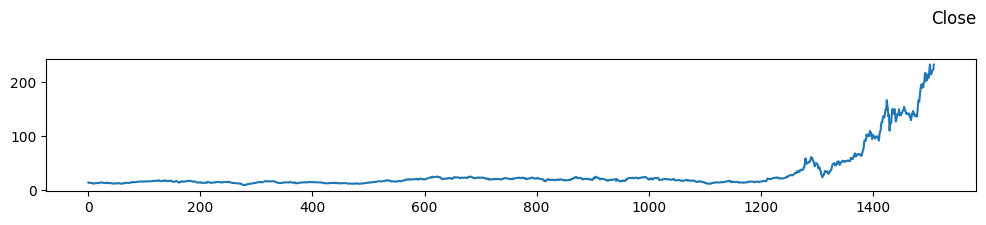

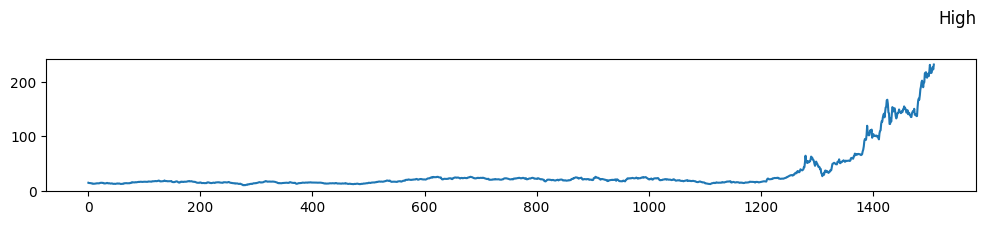

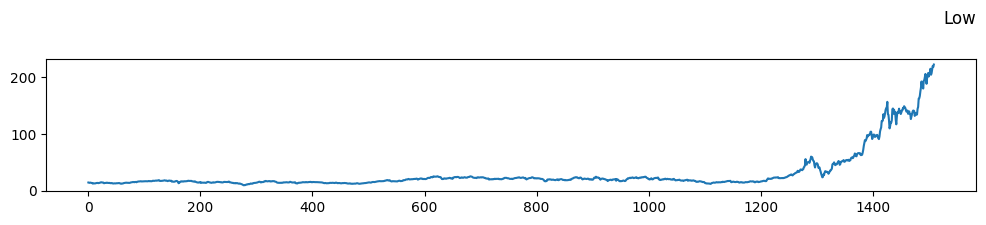

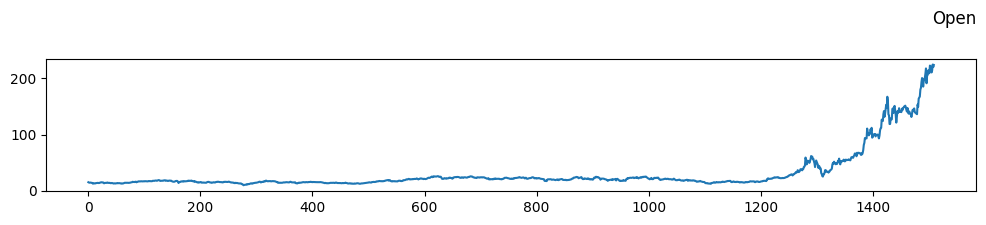

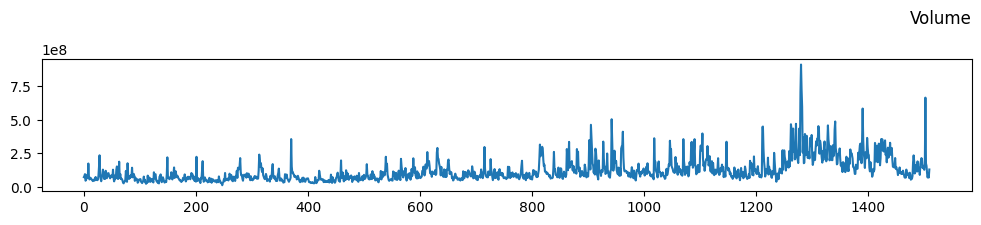

In [4]:
def stock_features_distibution(df, selected_stock):
    # Select the stock
    df = df[df["Stock"]==selected_stock]
    df.index = df["Date"]
    df = df.drop(columns=["Date","Stock"])
    values = df.values

    # specify columns to plot
    groups = [1, 2, 3, 4, 5]
    i = 1

    # plot each column
    print("For ", selected_stock, " :")
    plt.figure()
    for group in groups:
        plt.figure(figsize=(12, 10))
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=1.2, loc='right')
        i += 1
    plt.show()
    
    
stock_features_distibution(df, "TSLA")

# 4. <a id='toc4_'></a>[LSTM](#toc0_)

In [3]:
# Functions

# Prepare the data
def prepare_data(df, choosen_stock, look_back, years_to_include):
    # Choose specific stock
    data = df[df["Stock"]==choosen_stock ]
    data = df[df["Date"].dt.year.isin(years_to_include)]

    # Feature selection and engineering
    # Consider only the 'Close' column
    data = data["Close"].values
    data = data.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    train_size = int(len(data) * 0.7)
    valid_size = int(len(data) * 0.15)
    test_size = len(data) - train_size - valid_size
    
    train_data, test_data = data[0:train_size], data[train_size:(train_size + test_size)]
    train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]
    
    # train_X, train_Y = create_sequences(train_data, look_back)
    # valid_X, valid_Y = create_sequences(valid_data, look_back)
    # test_X, test_Y = create_sequences(test_data, look_back)
    
    # # Split data into training and testing sets
    # train_size = int(len(data) * 0.8)
    # train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    train_X, train_Y = create_sequences(train_data, look_back)
    valid_X, valid_Y = create_sequences(valid_data, look_back)
    test_X, test_Y = create_sequences(test_data, look_back)
    
    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X).view(-1, 1, look_back)
    train_Y = torch.Tensor(train_Y).view(-1, 1)
    valid_X = torch.Tensor(valid_X).view(-1, 1, look_back)
    valid_Y = torch.Tensor(valid_Y).view(-1, 1)
    test_X = torch.Tensor(test_X).view(-1, 1, look_back)
    test_Y = torch.Tensor(test_Y).view(-1, 1)
    
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    
def train_evaluate_lstm(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, valid_X, valid_Y):
    # Initialize the model
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs, train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
        model.eval()
        val_outputs = model(test_X)
        val_loss = criterion(val_outputs, test_Y)
        val_losses.append(val_loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    train_predict = model(train_X)
    val_predict = model(valid_X)
    test_predict = model(test_X)

    # Inverse transform the predictions to the original scale
    train_predict = scaler.inverse_transform(train_predict.detach().numpy())
    train_Y = scaler.inverse_transform(train_Y.numpy())
    valid_predict = scaler.inverse_transform(val_predict.detach().numpy())
    valid_Y = scaler.inverse_transform(valid_Y.numpy())
    test_predict = scaler.inverse_transform(test_predict.detach().numpy())
    test_Y = scaler.inverse_transform(test_Y.numpy())

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared= False)
    val_rmse = mean_squared_error(valid_Y, valid_predict, squared= False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared= False)
    
    # Visualize training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, loss, train_rmse, val_rmse, test_rmse

In [34]:
# Functions

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.squeeze(y_true), np.squeeze(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Prepare the data
def prepare_data_uni(df, choosen_stock, look_back, years_to_include):
    # Choose specific stock
    data = df[df["Stock"]==choosen_stock ]
    
    # Filter data for years 2015-2018 for training
    train_data = data[data["Date"].dt.year.isin(range(2015, 2019))]
    valid_size = int(len(data) * 0.10)
    train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]

    # Filter data for the year 2019 for testing
    test_data = data[data["Date"].dt.year == 2019]
    # test_data = data[(data["Date"].dt.year == 2019) & (data["Date"].dt.month.isin([1]))]
    # test_data = data[(data["Date"] >= "2019-01-01") & (data["Date"] <= "2019-01-10")]

    # Feature selection and engineering
    # Consider only the 'Close' column
    train_data = train_data["Close"].values
    valid_data = valid_data["Close"].values
    test_data = test_data["Close"].values
    train_data = train_data.reshape(-1, 1)
    valid_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    train_X, train_Y = create_sequences(train_data, look_back)
    valid_X, valid_Y = create_sequences(valid_data, look_back)
    test_X, test_Y = create_sequences(test_data, look_back)
    
    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X).view(-1, 1, look_back)
    train_Y = torch.Tensor(train_Y).view(-1, 1)
    valid_X = torch.Tensor(valid_X).view(-1, 1, look_back)
    valid_Y = torch.Tensor(valid_Y).view(-1, 1)
    test_X = torch.Tensor(test_X).view(-1, 1, look_back)
    test_Y = torch.Tensor(test_Y).view(-1, 1)
    
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    
def train_evaluate_lstm_uni(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False):
    # Initialize the model
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs, train_Y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(test_X)
        val_loss = criterion(val_outputs, test_Y)
        val_losses.append(val_loss.item())
        
        if visualize == True:
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    train_predict = model(train_X)
    valid_predict = model(valid_X)
    test_predict = model(test_X)

    # Inverse transform the predictions to the original scale
    train_predict = scaler.inverse_transform(train_predict.detach().numpy())
    train_Y = scaler.inverse_transform(train_Y.numpy())
    valid_predict = scaler.inverse_transform(valid_predict.detach().numpy())
    valid_Y = scaler.inverse_transform(valid_Y.numpy())
    test_predict = scaler.inverse_transform(test_predict.detach().numpy())
    test_Y = scaler.inverse_transform(test_Y.numpy())
    
    # Compute MAPE
    train_mape = mean_absolute_percentage_error(train_Y, train_predict)
    valid_mape = mean_absolute_percentage_error(valid_Y, valid_predict)
    test_mape = mean_absolute_percentage_error(test_Y, test_predict)

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared= False)
    valid_rmse = mean_squared_error(valid_Y, valid_predict, squared= False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared= False)
    
    if visualize == True:
        # Visualize training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
            
        # Visualize test and predictions
        plt.figure(figsize=(10, 5))
        plt.plot(test_Y, label='True', linewidth=2)
        plt.plot(test_predict, label='Predicted', linewidth=2)
        plt.title("Test vs. Predicted Prices")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape

In [36]:
## Tuning

# Load the data
df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5, 10, 30]  # Adjust the look_back window values as needed
hidden_size_values = [64, 128]  # Adjust the hidden_size values as needed
num_layers_values = [2, 3, 4]  # Adjust the num_layers values as needed
learning_rate_values = [0.005, 0.01, 0.02]  # Adjust the learning_rate values as needed
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

best_models = []
top_k = 5  # Get the top 5 performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_uni(df, choosen_stock, look_back, years_to_include)
                model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_uni(look_back, hidden_size, num_layers, 1, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler)
                best_models.append({
                    "look_back": look_back,
                    "hidden_size": hidden_size,
                    "num_layers": num_layers,
                    "learning_rate": learning_rate,
                    "train_rmse": train_rmse,
                    "valid_rmse": valid_rmse,
                    "test_rmse": test_rmse,
                    "train_mape": train_mape,
                    "valid_mape": valid_mape,
                    "test_mape": test_mape,
                })

# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])


Top 5 Performing Models:
[{'hidden_size': 64,
  'learning_rate': 0.005,
  'look_back': 5,
  'num_layers': 2,
  'test_mape': 1.5079885721206665,
  'test_rmse': 1.2021025,
  'train_mape': 2.0572280511260033,
  'train_rmse': 1.0131959,
  'valid_mape': 2.0572280511260033,
  'valid_rmse': 1.0131959},
 {'hidden_size': 128,
  'learning_rate': 0.005,
  'look_back': 5,
  'num_layers': 2,
  'test_mape': 1.5559644438326359,
  'test_rmse': 1.2048317,
  'train_mape': 1.6635052859783173,
  'train_rmse': 0.8943708,
  'valid_mape': 1.6635052859783173,
  'valid_rmse': 0.8943708},
 {'hidden_size': 128,
  'learning_rate': 0.005,
  'look_back': 10,
  'num_layers': 2,
  'test_mape': 2.4327484890818596,
  'test_rmse': 1.813979,
  'train_mape': 1.991584524512291,
  'train_rmse': 1.0895069,
  'valid_mape': 1.991584524512291,
  'valid_rmse': 1.0895069},
 {'hidden_size': 128,
  'learning_rate': 0.01,
  'look_back': 5,
  'num_layers': 2,
  'test_mape': 2.5840280577540398,
  'test_rmse': 1.9160339,
  'train_mape

Epoch [20/100], Training Loss: 0.0327, Validation Loss: 0.1577
Epoch [40/100], Training Loss: 0.0016, Validation Loss: 0.0078
Epoch [60/100], Training Loss: 0.0011, Validation Loss: 0.0015
Epoch [80/100], Training Loss: 0.0008, Validation Loss: 0.0013
Epoch [100/100], Training Loss: 0.0007, Validation Loss: 0.0011


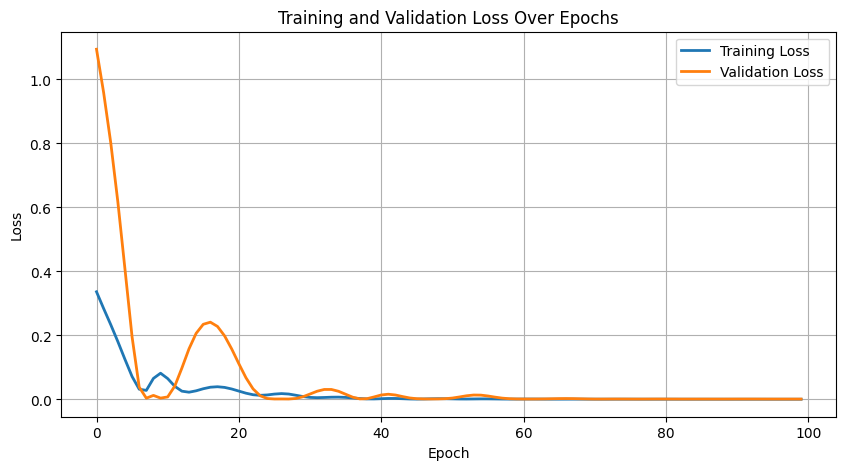

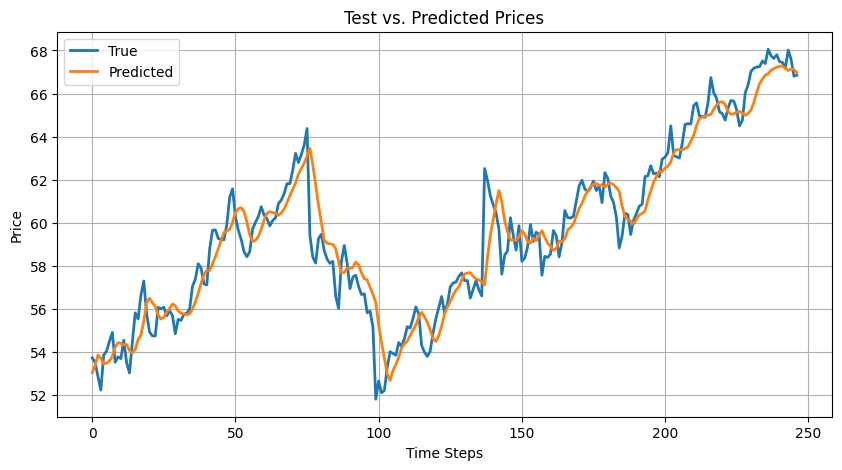

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [32]:
## Standalone code

# Hyperparameters
choosen_stock = "GOOG" # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back = 5  # Adjust the look_back window as needed
input_size = look_back
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.005
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

# Prepare the data
# print("Data Preparation")
train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_uni(df, choosen_stock, look_back, years_to_include)

# Train the model
# print("\nTraining")
model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_uni(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=True)

print(model)